In [1]:
import os, glob, datetime

import pandas as pd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import properscoring as ps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import seaborn as sns

from scores_utils import *
from functional_utils import _fDepth, _fQuantile

from loading_utils import (_process_metadata, 
                           _process_training_curves, 
                           _process_testing_curves, 
                           _process_traning_forecasts, 
                           _process_testing_forecasts)

from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from ipywidgets import *
from scipy.stats import multivariate_normal, norm
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams['font.family']         = 'Avenir'

path_to_fDepth = '/Users/Guille/Desktop/dynamic_update/functional_forecast_dynamic_update/fDepth'
path_to_data   = '/Users/Guille/Desktop/dynamic_update/data'
path_to_images = '/Users/Guille/Desktop/dynamic_update/images'

## Historical random curves and day-ahead forecasts

In [2]:
# Resource
resource = 'wind'

# Timestamps in interval
T = 288
K = 264

# Loading color palette
palette_ = pd.read_csv(path_to_data + '/palette.csv')
print(palette_)

# Loading Texas map
TX_ = gpd.read_file(path_to_data + '/maps/TX/State.shp')

# Loading and processing of sites metadata
meta_ = _process_metadata(file_name = '/wind_meta.xlsx', 
                          path      = path_to_data)

# Loading and processing of historical curves for the training dataset
F_tr_, T_tr_, x_tr_, assets_, p_ = _process_training_curves(meta_, T, K,
                                                            file_name = '/actuals/wind_actual_5min_site_2017.csv',
                                                            path      = path_to_data)
print(F_tr_.shape, T_tr_.shape, x_tr_.shape, assets_.shape, p_.shape)

# Loading and processing of historical curves for the testing dataset
F_ts_, T_ts_, x_ts_ = _process_testing_curves(meta_, assets_, p_, T, K,
                                              file_name = '/actuals/wind_actual_5min_site_2018.csv',
                                              path      = path_to_data)
print(F_ts_.shape, T_ts_.shape, x_ts_.shape)

# Loading and processing of historical day-ahead forecast for the training dataset
E_tr_ = _process_traning_forecasts(assets_, p_, T, K, 
                                   file_name = '/actuals/wind_day_ahead_forecast_2017.csv',
                                   path      = path_to_data)
print(E_tr_.shape)

# Loading and processing of historical day-ahead forecast for the testing dataset
E_ts_ = _process_testing_forecasts(assets_, p_, T, K, 
                                   file_name = '/actuals/' + resource + '_day_ahead_forecast_2018.csv', 
                                   path      = path_to_data)
print(E_ts_.shape)

dt_ = np.array([t*5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({'time': dt_}).time, unit = 'm').dt.strftime('%H:%M').to_numpy()
print(dt_.shape, dx_.shape)

      miro      ibm
0  #013396  #648FFF
1  #B1C06E  #785EF0
2  #056534  #DC267F
3  #F80202  #FE6100
4  #FDD906  #FFB000
5  #FCF795      NaN
6  #CCEDFF      NaN
7  #FDD60B      NaN
8  #FCE9D0      NaN
0.0 1.0
(95832, 288) (95832,) (95832, 2) (264,) (264,)
0.0 1.0
(365, 288, 264) (365,) (264, 2)
0.0 0.9999999888984703
(95832, 288)
0.0 1.0
(365, 288, 264)
(288,) (288,)


# Functional k-NNs

In [3]:
# Calculate weighted (w_) distance between X_ and x_
def _dist(X_, x_, w_ = []):
    if len(w_) == 0:
        w_ = np.ones(x_.shape)
    w_ = w_/w_.sum()
    d_ = np.zeros((X_.shape[0], ))
    for i in range(X_.shape[0]):
        d_[i] = w_.T @ (X_[i, :] - x_)**2
    return d_

# Radial Basis function kernel based on distance (d_)
def _kernel(d_, length_scale):
    w_ = np.exp(-d_/length_scale)
    return w_#/w_.sum()

def _inv_dist(d_, length_scale):
    w_ = 1./(d_ + length_scale)
    return w_#/w_.sum()

# Define exponential growth function
def _exponential_growth(t, dacay_rate, innit = 0):
    tau_ = np.linspace(t - 1, 0, t)
    return np.exp(-dacay_rate*tau_)

# Define exponential dacay function
def _exponential_decay(S, dacay_rate):
    s_ = np.linspace(0, S - 1, S)
    return np.exp(-dacay_rate*s_)

def _haversine_dist(x_1_, x_2_):
    """
    Calculate the distance between two points on Earth using the Haversine formula.

    Args:
        x_1_ (float): Longitude and latitude of the first point in degrees.
        x_2_ (float): Longitude and latitude of the second point in degrees.

    Returns:
        float: Distance between the two points in kilometers.
    """
    R = 6371  # Radius of Earth in kilometers
    
    dlat_ = np.deg2rad(x_2_[:, 1]) - np.deg2rad(x_1_[1])
    dlon_ = np.deg2rad(x_2_[:, 0]) - np.deg2rad(x_1_[0])
    
    theta = np.sin(dlat_/2)**2 + np.cos(np.deg2rad(x_1_[1]))*np.cos(np.deg2rad(x_2_[:, 1]))*np.sin(dlon_/2)**2
    
    return 2.*R*np.arcsin(np.sqrt(theta))

def _logistic(x_, k = 1.):
    return 1. / (1. + np.exp( - k*x_))

# # Fuse day-ahead forecast with real-time forecast
# def _update_forecast(F_ac_, f_hat_, fc_, update_rate):

#     w_update_ = 1. - _exponential_decay_plus(F_ac_.shape[1] + 1, update_rate)[1:]
#     #w_update_ = eta_/eta_.max()
#     f_update_ = f_hat_*(1. - w_update_) + fc_*w_update_

#     plt.figure(figsize = (10, 2))
#     plt.title('Trust Rate')
#     plt.plot(w_update_)
#     plt.show()

#     return f_update_

# Define a function to calculate quantiles
def _KDE_quantile(_KDE, q_, x_min     = 0., 
                            x_max     = 1., 
                            n_samples = 1000):
    
    """
    Calculates the quantile for a given probability using KDE.

    Parameters:
    _KDE: Kernel density estimate object (e.g., from scipy.stats.gaussian_kde).
    q:    Probability value (between 0 and 1) for which to calculate the quantile.

    Returns:
    The quantile value.
    """

    # Calculate CDF
    x_ = np.linspace(x_min, x_max, n_samples)
    #z_ = np.exp(_KDE.score_samples(x_[:, np.newaxis]))
    w_ = np.cumsum(np.exp(_KDE.score_samples(x_[:, np.newaxis])))
    # Normalize CDF
    w_ /= w_[-1] 
    
    return np.interp(np.array(q_), w_, x_), np.interp(1. - np.array(q_), w_, x_)

# Silverman's Rule
def _silverman_rule(x_):
    IQR = np.percentile(x_, 75) - np.percentile(x_, 25)
    return 0.9 * min(np.std(x_), IQR / 1.34) * x_.shape[0] ** (-1/5)

In [5]:
# d = 11 high day-ahead error
# d = 5 low day-ahead error
# When we do the max in the similarity, it should be min intead.
# sparsest: (array([ 33,  84,  89,  92, 148, 176, 249, 256]), array([7, 6, 8, 6, 8, 8, 8, 6]))
# densest 15683.0: (array([195]), array([4]))
# densest: 99
# sprasest: 4

a = 0
d = 9
t = 12*12
file_name = f'{a}-{d}-{t}'
print(file_name)

# Weighting functions parameters
forget_rate_f = 1.
forget_rate_e = .5
lookup_rate   = .05

# Distance parameters
length_scale_f = .1
length_scale_e = .75

# Scenario selection paramters
xi        = 0.99
kappa_min = 50
kappa_max = 250

f_     = F_ts_[d, :t, a]
f_hat_ = F_ts_[d, t:, a]
e_     = E_ts_[d, :, a]

# Get constants
T    = E_ts_.shape[1]
tau_ = dt_[:t]
s_   = dt_[t:]

# phi: importance weights based on past time distance
phi_ = _exponential_growth(t, forget_rate_f)

# psi: importance weights based on past and future time distance
psi_1_ = _exponential_growth(t, forget_rate_e)
psi_2_ = _exponential_decay(t, lookup_rate)
psi_   = np.concatenate([psi_1_, psi_2_], axis = 0)

# d: euclidian distance between samples weighted by importance weights
d_f_ = _dist(F_tr_[:, :t], f_, w_ = phi_)
d_e_ = _dist(E_tr_, e_, w_ = psi_)
print(x_tr_.shape, x_ts_.shape)
d_s_ = _haversine_dist(x_ts_[a, :], x_tr_)

# w: normalized weights distance across observations based sigmoid link function
# w_f_ = _inv_dist(d_F_, length_scale)
# w_e_ = _inv_dist(d_E_, length_scale)

# w: normalized weights distance across observations based exponential link function
w_f_ = _kernel(d_f_, length_scale_f)
w_e_ = _kernel(d_e_, length_scale_e)
W_   = np.stack([w_f_, w_e_])
w_   = np.min(W_, axis = 0)
idx_0_ = np.argmin(W_, axis = 0)

# idx_ = w_e_ > 0.775
# idx_ = idx_ & (w_e_ < 0.8)
# plt.figure()
# plt.plot(E_tr_[idx_, :].T, color = 'gray')
# plt.show()

idx_bool_ = w_ > xi
print(kappa_min, idx_bool_.sum(), kappa_max, w_.shape)

idx_1_ = np.arange(w_.shape[0])[idx_bool_]
if idx_bool_.sum() > kappa_max:
    idx_bool_ = idx_bool_ & (d_s_ < np.sort(d_s_[idx_bool_])[kappa_max])
if idx_bool_.sum() < kappa_min:
    idx_bool_ = w_ > np.sort(w_)[::-1][kappa_min]
idx_2_ = np.arange(w_.shape[0])[idx_bool_]
#print(idx_2_.shape)

# eta: importance weights based on future time distance
rmse  = np.sqrt(np.mean((e_[:t] - f_)**2))
wrmse = np.sqrt(np.sum(psi_1_*(e_[:t] - f_)**2)/psi_1_.sum())

trust_rate = .005
#eta_ = 1. - _exponential_decay(t, trust_rate)
#eta_ = 1. - _exponential_decay(t, trust_rate/wrmse)
#eta_ = _logistic(s_ - (t*5 + 9*12*5), k = trust_rate)
eta_ = _logistic(s_ - (t*5 + 9*12*5), k = trust_rate/wrmse)
#print(rmse, wrmse, (t*5 + 9*12*5), 10/(0.01 + rmse**2))

M_ = np.zeros((idx_2_.shape[0], eta_.shape[0]))
for i, j in zip(idx_2_, range(idx_2_.shape[0])):
    M_[j, :] = F_tr_[i, t:]*(1. - eta_) + E_tr_[i, t:]*eta_

0-9-144
(95832, 2) (264, 2)
50 351 250 (95832,)


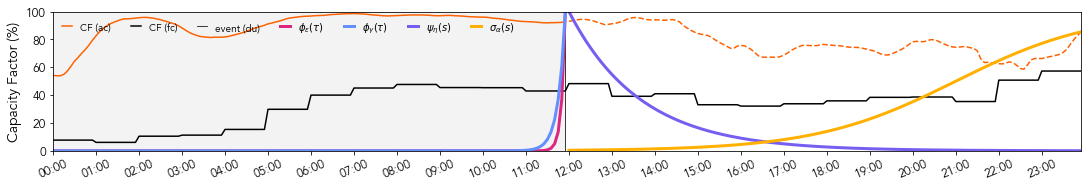

In [10]:
def _plot_forecast_parameters(f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t):
    
    tau_ = dt_[:t]
    s_   = dt_[t:]
    
    fig, ax_ = plt.subplots(1, 1, figsize = (15, 2.5), layout = 'constrained')
    
    ax_.plot(tau_, 100.*f_, c     = palette_.loc[3, 'ibm'], 
                            label = 'CF (ac)', 
                            lw    = 1.5)
    
    ax_.plot(s_, 100.*f_hat_, c  = palette_.loc[3, 'ibm'], 
                              lw = 1.5, 
                              ls = '--')
    
    ax_.plot(dt_, 100.*e_, lw    = 1.5, 
                           label = 'CF (fc)',
                           c     = 'k')
    
    ax_.fill_between(tau_, 100.*np.ones(tau_.shape), 100.*np.zeros(tau_.shape), color = 'lightgray', 
                                                                                alpha = .25)
    
    ax_.axvline(dt_[t - 1], color = 'k',
                            lw    = 0.75, 
                            label = 'event (du)')
    
    ax_.plot(tau_, 100.*phi_, c     = palette_.loc[2, 'ibm'], 
                              lw    = 3, 
                              label = r'$\phi_{\varepsilon} (\tau)$') 
    
    ax_.plot(tau_, 100.*psi_[:t], c     = palette_.loc[0, 'ibm'], 
                                  lw    = 3, 
                                  label = r'$\phi_{\gamma} (\tau)$')  
    
    ax_.plot(s_, 100.*psi_[t:], c     = palette_.loc[1, 'ibm'], 
                                lw    = 3, 
                                label = r'$\psi_{\eta} (s)$')  
    
    ax_.plot(s_, 100.*eta_, c     = palette_.loc[4, 'ibm'], 
                            lw    = 3, 
                            label = r'$\sigma_{\alpha} (s) $')
    
    ax_.set_xticks(dt_[::12], dx_[::12], rotation = 22.5)
    ax_.set_ylabel('Capacity Factor (%)', size = 14)
    ax_.tick_params(axis = 'both', labelsize = 12)

    ax_.set_ylim(0., 100.)
    ax_.set_xlim(dt_[0], dt_[-1])
    ax_.legend(frameon = False, 
               ncol    = 10, 
               loc     = 'upper left')

    plt.savefig(path_to_images + r'/parameters.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    

_plot_forecast_parameters(f_, e_, f_hat_, phi_, psi_, eta_, dx_, dt_, t)

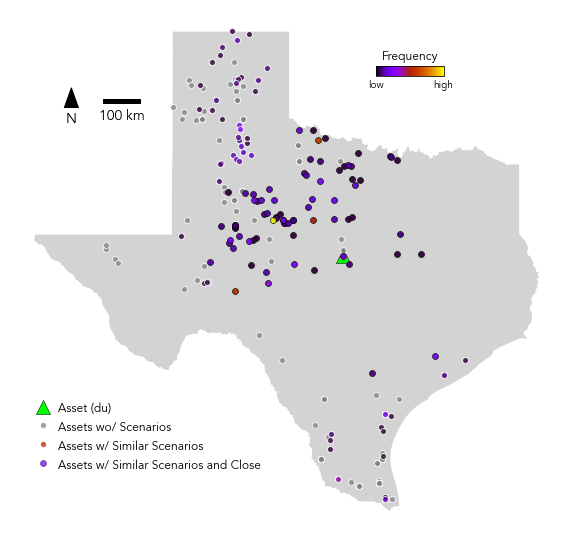

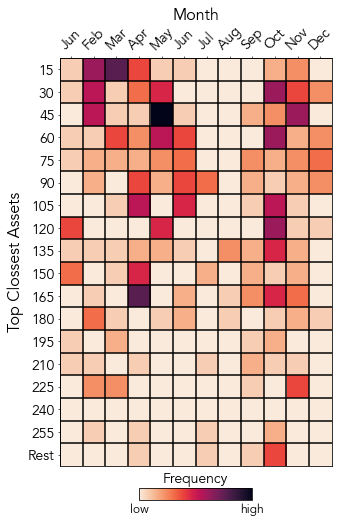

In [11]:
def _plot_frequency_map(x_tr_, x_ts_, x_, idx_0_, idx_1_, idx_2_):

    x_tr_p_, z_tr_p_   = np.unique(x_tr_[idx_1_, :], return_counts = True, axis = 0)
    x_tr_pp_, z_tr_pp_ = np.unique(x_tr_[idx_2_, :], return_counts = True, axis = 0)
    
    #_cmap = plt.get_cmap('gnuplot')
    _cmap = sns.color_palette("gnuplot", as_cmap=True)
    
    _norm = plt.Normalize(0., z_tr_p_.max())
    
    fig, ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as needed

    TX_.plot(ax        = ax, 
             facecolor = 'lightgray', 
             edgecolor = 'white', 
             zorder    = 0)

    ax.scatter(x_[0], x_[1], 
               c      = 'lime', 
               lw     = 0.5, 
               ec     = 'k', 
               s      = 200., 
               zorder = 1, 
               marker = '^', 
               label  = 'Asset (du)') 
    
    ax.plot(x_ts_[:, 0], x_ts_[:, 1], 
            c      = 'gray', 
            alpha  = .75,
            ms     = 6, 
            marker = 'o', 
            mec    = 'w',
            ls     = 'none', 
            mew    = 1.,
            zorder = 2, 
            label  = 'Assets wo/ Scenarios') 
    
    ax.plot(x_tr_[idx_1_[0], 0], x_tr_[idx_1_[0], 1], 
            c      = _cmap(_norm(z_tr_p_.max()/2.)), 
            alpha  = 0.75,
            ms     = 6,
            ls     = 'none',
            marker = 'o', 
            mec    = 'w',
            mew    = 1.,
            zorder = 3, 
            label  = 'Assets w/ Similar Scenarios')

    ax.plot(x_tr_[idx_2_[0], 0], x_tr_[idx_2_[0], 1], 
            c      = _cmap(_norm(z_tr_p_.max()/4.)), 
            alpha  = 0.75,
            ms     = 6,
            ls     = 'none',
            marker = 'o', 
            mec    = 'k',
            mew    = 0.5,
            zorder = 3, 
            label  = 'Assets w/ Similar Scenarios and Close')
        
    for i in np.arange(x_tr_p_.shape[0], dtype = int)[np.argsort(z_tr_p_)]:
        ax.plot(x_tr_p_[i, 0], x_tr_p_[i, 1], 
                c      = _cmap(_norm(z_tr_p_[i])), 
                alpha  = 0.75,
                ms     = 6,
                ls     = 'none',
                marker = 'o', 
                mec    = 'w',
                mew    = 1.,
                zorder = 4)
        
    for i in np.arange(x_tr_pp_.shape[0], dtype = int)[np.argsort(z_tr_pp_)]:
        ax.plot(x_tr_pp_[i, 0], x_tr_pp_[i, 1], 
                c      = _cmap(_norm(z_tr_pp_[i])), 
                alpha  = 0.75,
                ms     = 6,
                ls     = 'none',
                marker = 'o', 
                mec    = 'k',
                mew    = 1.,
                zorder = 5)
        
    cbar = fig.colorbar(cm.ScalarMappable(cmap = _cmap), 
                 cax = ax.inset_axes([-97.75, 35.5, 1.75, .225], transform = ax.transData), 
                 orientation = 'horizontal')

    cbar.set_ticks([0, 1], labels = ['low', 'high'])
    cbar.ax.tick_params(length = 0)
    cbar.ax.set_title('Frequency', rotation = 0)
        
    ax.legend(frameon = False, 
              #loc     = 'upper left',
              bbox_to_anchor = (0.475, 0.275),
              ncol    = 1, fontsize = 12)    

    # Add compass (North arrow)
    x, y, arrow_length = 0.115, 0.85, .0625  # relative axes coords
    ax.annotate('N', xy         = (x, y), 
                     xytext     = (x, y - arrow_length),
                     arrowprops = dict(facecolor='k', arrowstyle = 'wedge,tail_width=1,shrink_factor=.5' ),
                     ha         = 'center', 
                     va         = 'center',
                     fontsize   = 14,
                     xycoords   = ax.transAxes)

    scalebar = ScaleBar(dx              = 100,  # scaling factor
                        units           = 'km', 
                        dimension       = 'si-length',  # could also be 'imperial-length'
                        location        = 'upper left',
                        length_fraction = .075,  # fraction of the axis for bar length
                        color           = 'black',
                        box_color       = 'None',
                        box_alpha       = 1.,
                        border_pad      = 9,
                        font_properties = {'size': 14})
    
    ax.add_artist(scalebar)

    ax.set_axis_off()

    plt.savefig(path_to_images + r'/frequency_map.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()


def _selected_scenarios_heatmap(T_tr_, T_ts_, x_ts_, idx_1_, idx_2_):
    
    N     = 17
    delta = 15
    
    d_      = _haversine_dist(x_ts_[a, :], x_ts_)
    d_sort_ = np.sort(d_)

    tops_      = [int((i+1)*delta) for i in range(N)]
    intervals_ = [d_sort_[i] for i in tops_]

    m_a   = datetime.datetime.strptime(T_ts_[d], "%Y-%m-%d").timetuple().tm_yday - 1
    m_tr_ = np.stack([datetime.datetime.strptime(T_tr_[i], "%Y-%m-%d").timetuple().tm_mon - 1
                      for i in range(T_tr_.shape[0])])

    K        = 0
    heatmap_ = np.zeros((N + 1, m_tr_.max() + 1))
    for d_s, m in zip(d_s_[idx_1_], m_tr_[idx_1_]):
        heatmap_[np.searchsorted(intervals_, d_s), m] += 1
        K += 1

    _cmap = sns.color_palette("rocket_r", as_cmap = True)

    month_ = ['Jun', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    #print(K, month_[m_a])
    fig, ax = plt.subplots(figsize = (5, 7.5))  # Adjust figure size as needed
    ax.matshow(heatmap_, 
               cmap   = _cmap, 
               vmin   = 0., 
               extent = [0, 12, N + 1, 0])

    ax.set_xticks(range(len(month_)), []*len(month_))
    ax.set_yticks(range(len(tops_) + 1), []*(len(tops_) + 1))

    ax.set_ylabel('Top Clossest Assets', size = 16)
    ax.set_xlabel('Month', size = 16)
    ax.xaxis.set_label_position('top') 

    ax.set_xticks(np.arange(len(month_), dtype = int) + 0.5, month_, rotation = 45, minor = True, size = 14)
    ax.set_yticks(np.arange(len(tops_) + 1, dtype = int) + 0.5, tops_ + ['Rest'], minor = True, size = 14)

    ax.tick_params(which  = 'major', 
                   bottom = False, 
                   left   = False, 
                   top    = False)
    
    ax.tick_params(which  = 'minor', 
                   bottom = False)
    
    ax.grid(which     = 'major', 
            color     = 'k', 
            linestyle = '-', 
            linewidth = 1.5)

    cbar = fig.colorbar(cm.ScalarMappable(cmap = _cmap), 
                        cax = ax.inset_axes([3.5, 19, 5., .5], transform = ax.transData), 
                        orientation = 'horizontal')

    cbar.set_ticks([0, 1], labels = ['low', 'high'], size = 12)
    cbar.ax.tick_params(length = 0)
    cbar.ax.set_title('Frequency', rotation = 0, size = 14)

    plt.savefig(path_to_images + r'/frequency_heatmap.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    
_plot_frequency_map(x_tr_, x_ts_, x_ts_[a, :], idx_0_, idx_1_, idx_2_)
_selected_scenarios_heatmap(T_tr_, T_ts_, x_ts_, idx_1_, idx_2_)

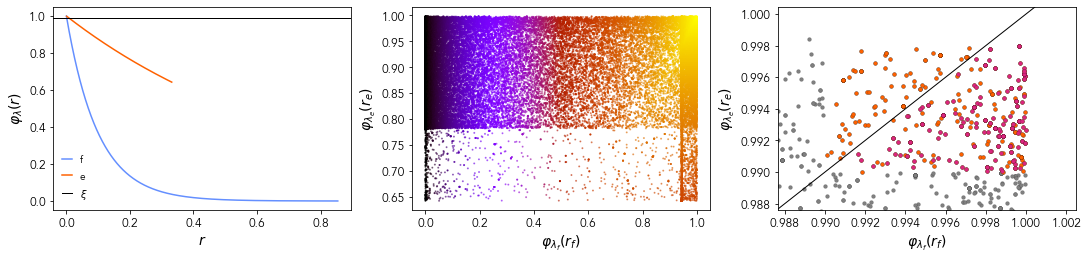

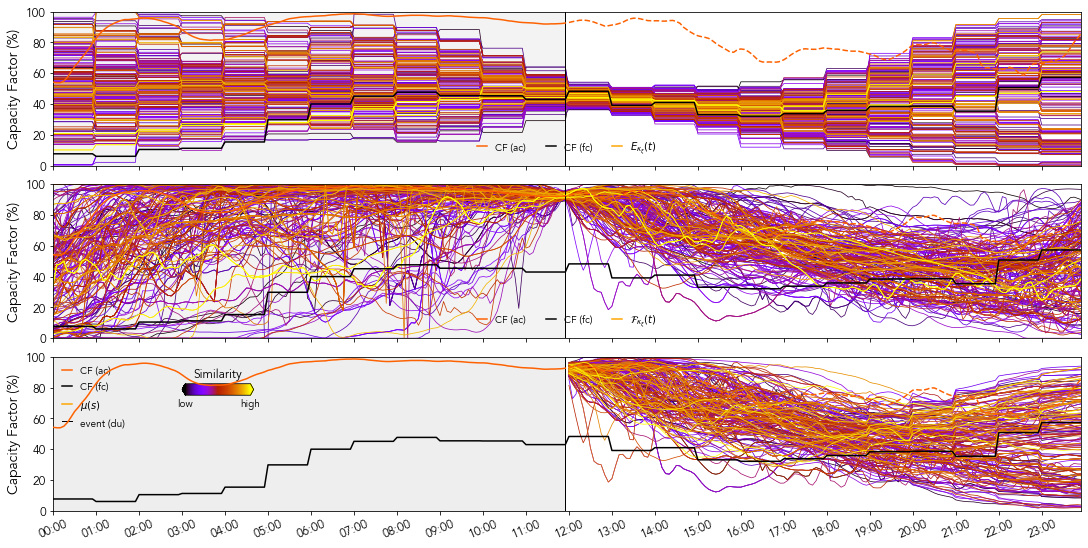

In [12]:
def _fneighborhood(d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi):

    _cmap = plt.get_cmap('gnuplot')
    _norm = plt.Normalize(w_.min(), w_.max())
    
    fig, ax_ = plt.subplots(1, 3, figsize = (15, 3.5), layout = 'constrained')
    
    ax_[0].plot(d_f_[np.argsort(d_f_)], w_f_[np.argsort(d_f_)], c     = palette_.loc[0, 'ibm'], 
                                                                label = 'f')
    ax_[0].plot(d_e_[np.argsort(d_e_)], w_e_[np.argsort(d_e_)], c     = palette_.loc[3, 'ibm'], 
                                                                label = 'e')
    
    ax_[0].axhline(xi, color  = 'k', 
                       lw     = 1., 
                       label  = r'$\xi$', 
                       zorder = 10)
        
    ax_[0].set_ylabel(r'$\varphi_{\lambda} (r)$', size = 14)
    ax_[0].set_xlabel(r'$r$', size = 14)
    ax_[0].tick_params(axis = 'both', labelsize = 12)
    ax_[0].legend(frameon = False)
    #plt.xlim(0, 1)
    #plt.ylim(0, 1)

    ax_[1].scatter(w_f_, w_e_, c     = _cmap(_norm(w_)), 
                               s     = 1., 
                               alpha = 0.5)
    
    ax_[1].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
    ax_[1].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
    ax_[1].tick_params(axis = 'both', labelsize = 12)
    #plt.xlim(0, 1)
    #plt.ylim(0, 1)
    
#     ax_[2].scatter(w_f_, w_e_, c = 'gray', 
#                                s = 1., 
#                                alpha = .5)
    
#     ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_], c = palette_.loc[3, 'imb'], 
#                                                s = 1, 
#                                                alpha = .5)
    
#     ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
#     ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
#     ax_[2].tick_params(axis = 'both', labelsize = 12)
    
    ax_[2].scatter(w_f_, w_e_, 
                   c     = 'gray', 
                   s     = 15., 
                   alpha = 1., 
                   lw    = .125, 
                   ec    = 'k')
    
    ax_[2].scatter(w_f_[idx_1_], w_e_[idx_1_], c     = palette_.loc[3, 'ibm'], 
                                               s     = 15, 
                                               alpha = 1., 
                                               lw    = .125, 
                                               ec    = 'k')

    c_ = [palette_.loc[6, 'ibm'], palette_.loc[2, 'ibm']]
    for i, j in zip(idx_2_, idx_0_[idx_2_]):
        ax_[2].scatter(w_f_[i], w_e_[i], c     = c_[j], 
                                         s     = 15, 
                                         lw    = .125, 
                                         ec    = 'k',
                                         alpha = 1.)
        
    ax_[2].axline((1, 1), slope = 1, lw = 1, c = 'k')
    ax_[2].set_ylabel(r'$\varphi_{\lambda_e} (r_{e})$', size = 14)
    ax_[2].set_xlabel(r'$\varphi_{\lambda_f} (r_{f})$', size = 14)
    ax_[2].tick_params(axis = 'both', labelsize = 12)
    ax_[2].set_xlim(w_f_[idx_2_].min()*0.9975, w_f_[idx_2_].max()*1.0025)
    ax_[2].set_ylim(w_e_[idx_2_].min()*0.9975, w_e_[idx_2_].max()*1.0025)
        
    plt.savefig(path_to_images + r'/fneighbor.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()
    
def _plot_selected_scenarios(F_tr_, E_tr_, M_, f_, w_, idx_, dx_, dt_, t):

    tau_ = dt_[:t]
    s_   = dt_[t:]
    
    z_   = (w_ - w_[idx_].min())/(w_[idx_].max() - w_[idx_].min())
    idx_ = idx_[np.argsort(w_[idx_])]

    _cmap = plt.get_cmap('gnuplot')
    _norm = plt.Normalize(z_[idx_].min(), z_[idx_].max())

    fig, ax_ = plt.subplots(3, 1, figsize = (15, 7.5), 
                                  sharex  = True, 
                                  layout  = 'constrained')

    ax_[0].plot(tau_, 100.*f_, c      = palette_.loc[3, 'ibm'], 
                               zorder = 10,
                               label  = 'CF (ac)', 
                               lw     = 1.5)
    
    ax_[0].plot(s_, 100.*f_hat_, c      = palette_.loc[3, 'ibm'], 
                                 zorder = 10,
                                 lw     = 1.5, 
                                 ls     = '--')
    
    ax_[0].plot(dt_, 100.*e_, lw     = 1.5, 
                              zorder = 10,
                              label  = 'CF (fc)',
                              c      = 'k')
    
    ax_[0].plot([], [], label = r'$E_{\kappa_{\xi}}(t)$', c = 'orange')
    for i, j in zip(idx_, range(idx_.shape[0])):
        ax_[0].plot(dt_, 100*E_tr_[i, :], c  = _cmap(_norm(z_[i])), 
                                          lw = .75) 
        
    ax_[0].fill_between(tau_, 100*np.ones(tau_.shape), 100*np.zeros(tau_.shape), 
                        color = 'lightgray', 
                        alpha = .25)
    
    ax_[0].axvline(dt_[t - 1], color = 'k', lw = 1.)
    ax_[0].set_xticks(dt_[::12], dx_[::12], rotation = 22.5)

    ax_[0].set_ylim(0., 100.)
    ax_[0].set_xlim(dt_[0], dt_[-1])
    ax_[0].set_ylabel('Capacity Factor (%)', size = 14)
    ax_[0].tick_params(axis = 'both', labelsize = 12)

    ax_[0].legend(frameon = False, 
                  ncol    = 10)
    
    ax_[1].plot(tau_, 100.*f_, c      = palette_.loc[3, 'ibm'], 
                               zorder = 10,
                               label  = 'CF (ac)', 
                               lw     = 1.5)
    
    ax_[1].plot(s_, 100.*f_hat_, c      = palette_.loc[3, 'ibm'], 
                                 zorder = 10,
                                 lw     = 1.5, 
                                 ls     = '--')
    
    ax_[1].plot(dt_, 100.*e_, lw     = 1.5, 
                              zorder = 10,
                              label  = 'CF (fc)',
                              c      = 'k')
    
    ax_[1].plot([], [], label = r'$\mathcal{F}_{\kappa_{\xi}}(t)$', 
                        c     = 'orange')
    for i, j in zip(idx_, range(idx_.shape[0])):
        ax_[1].plot(dt_, 100*F_tr_[i, :], c  = _cmap(_norm(z_[i])), 
                                          lw = .75) 
        
    ax_[1].fill_between(tau_, 100*np.ones(tau_.shape), 100*np.zeros(tau_.shape), color = 'lightgray', 
                                                                                 alpha = .25)
    
    ax_[1].axvline(dt_[t - 1], color = 'k', lw = 1.)
    ax_[1].set_xticks(dt_[::12], dx_[::12], rotation = 22.5)
    ax_[1].set_ylim(0., 100.)
    ax_[1].set_xlim(dt_[0], dt_[-1])
    ax_[1].set_ylabel('Capacity Factor (%)', size = 14)
    ax_[1].tick_params(axis = 'both', labelsize = 12)
    
    ax_[1].legend(frameon = False, 
                  ncol    = 10)
    
    ax_[2].plot(tau_, 100.*f_, c      = palette_.loc[3, 'ibm'], 
                               zorder = 10,
                               label  = 'CF (ac)', 
                               lw     = 1.5)
    
    ax_[2].plot(s_, 100.*f_hat_, c      = palette_.loc[3, 'ibm'], 
                                 zorder = 10,
                                 lw     = 1.5, 
                                 ls     = '--')
    
    ax_[2].plot(dt_, 100.*e_, lw     = 1.5, 
                              zorder = 10,
                              label  = 'CF (fc)',
                              c      = 'k')

    ax_[2].plot([], [], label = r'$\mu(s)$', 
                        c     = 'orange')
    
    for i, j in zip(idx_, range(M_.shape[0])):
        ax_[2].plot(dt_[t:], 100*M_[j, :], c  = _cmap(_norm(z_[i])), 
                                           lw = .75) 
    
    ax_[2].fill_between(tau_, 100*np.ones(tau_.shape), 100*np.zeros(tau_.shape), color = 'lightgray', 
                                                                                 alpha = .375)
    
    ax_[2].axvline(dt_[t - 1], 
                   color = 'k',
                   lw    = 1., 
                   label = 'event (du)')
    
    ax_[2].set_xticks(dt_[::12], dx_[::12], rotation = 22.5)
    #ax_[2].set_yticks(size = 12)
    ax_[2].set_ylim(0., 100.)
    ax_[2].set_xlim(dt_[0], dt_[-1])
    ax_[2].set_ylabel('Capacity Factor (%)', size = 14)
    
    ax_[2].tick_params(axis      = 'both', 
                       labelsize = 12)
    
    ax_[2].legend(frameon = False, 
                  loc     = 'upper left', 
                  ncol    = 1)
    
    cbar = fig.colorbar(cm.ScalarMappable(_norm, _cmap), 
                        cax         = ax_[2].inset_axes([180, 75, 100, 7.5], transform = ax_[2].transData), 
                        orientation = 'horizontal',
                        extend      = 'both')

    cbar.set_ticks([0, 1], labels = ['low', 'high'])
    cbar.ax.tick_params(length = 0)

    cbar.ax.set_title('Similarity', rotation = 0)

    plt.savefig(path_to_images + r'/scenarios_fc.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)

    plt.show()
    
_fneighborhood(d_f_, d_e_, w_f_, w_e_, w_, idx_0_, idx_1_, idx_2_, xi)
_plot_selected_scenarios(F_tr_, E_tr_, M_, f_, w_, idx_2_, dx_, dt_, t)

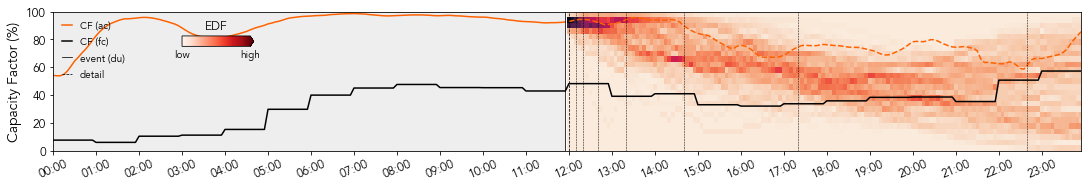

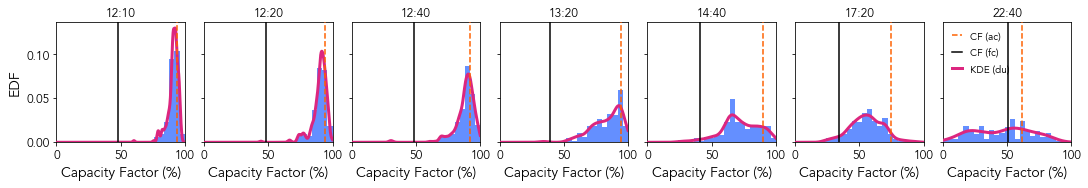

In [13]:
def _plot_histogram_cuts(M_, f_, e_, f_hat_, dx_, dt_, t, cuts_ = [2, 4, 8, 16, 32, 64, 128]):
    
    tau_ = dt_[:t]
    s_   = dt_[t:]
    
    x_ = np.linspace(0, 100, 1000)[:, np.newaxis]

    fig, ax_ = plt.subplots(1,len(cuts_), figsize = (15, 2.5), sharey = True, layout = 'constrained')

    for cut, i in zip(cuts_, range(len(cuts_))):
        _KD = KernelDensity(bandwidth = _silverman_rule(100*M_[:, cut]), 
                            algorithm = 'auto', 
                            kernel    = 'gaussian').fit(100*M_[:, cut][:, np.newaxis])
        
        ax_[i].axvline(100.*f_hat_[cut], color  = palette_.loc[3, 'ibm'], 
                                         lw     = 1.5,
                                         ls     = '--', 
                                         label  = 'CF (ac)', 
                                         zorder = 10)
        
        ax_[i].axvline(100.*e_[t + cut], color  = 'k', 
                                         lw     = 1.5,
                                         label  = 'CF (fc)', 
                                         zorder = 10)

        ax_[i].hist(100.*M_[:, cut], bins    = 25, 
                                     range   = (0, 100), 
                                     density = True, 
                                     color   = palette_.loc[0, 'ibm'], 
                                     zorder  = 8)
        
        ax_[i].plot(x_, np.exp(_KD.score_samples(x_)), label  = 'KDE (du)', 
                                                       color  = palette_.loc[2, 'ibm'], 
                                                       lw     = 3,
                                                       zorder = 9)
        ax_[i].set_title(dx_[t:][cut])
        ax_[i].set_xlim(0, 100)
        ax_[i].set_ylim(0, )
        ax_[i].set_xlabel('Capacity Factor (%)', size = 14)
        ax_[i].tick_params(axis = 'both', labelsize = 12)

    ax_[0].set_ylabel('EDF', size = 14)

    plt.legend(frameon = False)
    
    plt.savefig(path_to_images + r'/hist_cutoffs.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()

def _plot_density_heatmap(M_, f_, e_, f_hat_, dx_, dt_, t, cuts_ = [2, 4, 8, 16, 32, 64, 128]):
        
    tau_ = dt_[:t]
    s_   = dt_[t:]
    
    Z_ = []
    for i in range(M_.shape[1]):
        a_, b_ = np.histogram(100.*M_[:, i], bins    = 25, 
                                             range   = (0, 100), 
                                             density = True)
        Z_.append(a_)

    Z_     = np.stack(Z_).T
    X_, Y_ = np.meshgrid(dt_[t:], (b_[1:] + b_[:-1])/2.)

    fig, ax_ = plt.subplots(1, 1, figsize = (15, 2.5), 
                                  layout  = 'constrained')

    ax_.pcolormesh(X_, Y_, Z_, cmap = sns.color_palette("rocket_r", as_cmap = True))

    ax_.plot(tau_, 100.*f_, c     = palette_.loc[3, 'ibm'], 
                            lw    = 1.5,
                            label = 'CF (ac)')
    
    ax_.plot(s_, 100.*f_hat_, c  = palette_.loc[3, 'ibm'], 
                              lw = 1.5,
                              ls = '--')
    
    ax_.plot(dt_, 100.*e_, c     = 'k', 
                           lw    = 1.5,
                           label = 'CF (fc)')
    
    ax_.fill_between(tau_, 100.*np.ones(tau_.shape), 100.*np.zeros(tau_.shape), 
                     color = 'lightgray', 
                     alpha = .375)
    
    ax_.axvline(dt_[t - 1], color     = 'k', 
                            linewidth = .75, 
                            label     = 'event (du)')
    
    ax_.axvline(dt_[t], color = 'k', 
                        lw    = .75, 
                        ls    = '--', 
                        label = 'detail')
    
    for cut in cuts_:
        ax_.axvline(dt_[t + cut], color = 'k', 
                                  lw    = .5, 
                                  ls    = '--')

    ax_.set_xticks(dt_[::12], dx_[::12], rotation = 22.5)
    ax_.set_ylabel('Capacity Factor (%)', size = 14)
    ax_.tick_params(axis = 'both', labelsize = 12)
    ax_.set_ylim(0., 100.)
    ax_.set_xlim(dt_[0], dt_[-1])
    
    ax_.legend(frameon = False, 
               loc     = 'upper left', 
               ncol    = 1)

    cbar = fig.colorbar(cm.ScalarMappable(cmap = 'Reds'), 
                 cax = ax_.inset_axes([180, 75, 100, 7.5], transform = ax_.transData), 
                 orientation = 'horizontal', extend = 'max')

    cbar.set_ticks([0, 1], labels = ['low','high'])
    cbar.ax.tick_params(length = 0)

    cbar.ax.set_title('EDF', rotation = 0)

    plt.savefig(path_to_images + r'/eCDF_heatmap.pdf', 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    plt.show()

_plot_density_heatmap(M_, f_, e_, f_hat_, dx_, dt_, t)
_plot_histogram_cuts(M_, f_, e_, f_hat_, dx_, dt_, t)

KeyError: 'code'

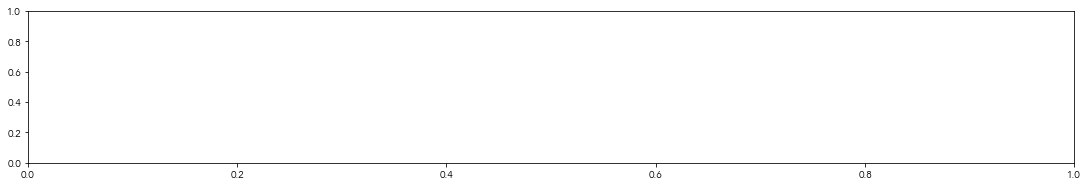

In [9]:
def _eQuantile(_eCDF, q_):
    
    """
    Calculates quantiles from an ECDF.

    Args:
    _eCDF: function from statsmodels api
    q_: A list or numpy array of quantiles to calculate (values between 0 and 1).

    Returns:
    _Q: A dictionary where keys are the input quantiles and values are the corresponding
    quantile values from the ECDF.
    """

    return np.array([_eCDF.x[np.searchsorted(_eCDF.y, q)] for q in q_])

def _plot_eQuantiles(Q_p_, f_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_):
    
    fig, ax_ = plt.subplots(1, 1, figsize = (15, 2.5), layout = 'constrained')

    ax_.plot(tau_, 100*f_, 
             c     = palette_.loc[0, 'code'], 
             label = 'CF (ac)')
    
    ax_.plot(s_, 100*f_hat_, 
             c  = palette_.loc[0, 'code'], 
             ls = '--')
    
    ax_.axvline(dt_[t - 1], 
                color = 'k', 
                lw    = 1., 
                label = 'event (du)')

    for i in range(int(len(q_)/2)):
        ax_.plot(s_p_, 100*Q_p_[:, i], 
                 lw     = .125, 
                 c      = 'lightgray', 
                 zorder = 1)
        
        ax_.plot(s_p_, 100*Q_p_[:, -i - 1], 
                 lw     = .125, 
                 c      = 'lightgray', 
                 zorder = 1)
        
        ax_.fill_between(s_p_, 100*Q_p_[:, i], 100*Q_p_[:, -i - 1], 
                         color  = 'gray', 
                         alpha  = .15 + i*0.15, 
                         label  = f'eCI {q_label_[i]}', 
                         zorder = 1)

    ax_.fill_between(tau_, 100*np.ones(tau_.shape), 100*np.zeros(tau_.shape), 
                     color = 'lightgray', 
                     alpha = .25)
    
    ax_.set_xticks(dt_[::12], dx_[::12], rotation = 22.5)
    ax_.set_ylim(0., 100.)
    ax_.set_xlim(dt_[0], dt_[-1])
    ax_.set_ylabel('Capacity Factor (%)', size = 14)
    ax_.tick_params(axis = 'both', labelsize = 12)

    ax_.legend(frameon = False, 
               loc     = 'upper left', 
               ncol    = 5)

    #plt.grid(axis = 'y', linestyle = ':', lw = 1., zorder = 10)

    plt.savefig(path_to_images + r'/eCI.pdf', 
                bbox_inches = 'tight', 
                dpi         = 600)

    plt.show()
    
# Extend quantiles to dynamic update event
M_p_ = np.concatenate([f_[-1]*np.ones((M_.shape[0], 1)), M_], axis = 1)
s_p_ = np.concatenate([tau_[-1]*np.ones((1,)), s_], axis = 0)

# Calculate quantiles from empirical distribution
q_       = [0.05, 0.1, 0.2, 0.8, 0.9, 0.95]
q_label_ = ['90%', '80%', '60%']

Q_p_ = np.stack([_eQuantile(ECDF(M_p_[:, i]), q_) for i in range(M_p_.shape[1])])

_plot_eQuantiles(Q_p_, f_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_)

In [ ]:
def _plot_fQuantiles(DQ_, M_, f_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_):

    plt.figure(figsize = (15, 2.5))

    plt.plot(tau_, 100.*f_, 
             c     = palette_.loc[0, 'code'], 
             label = 'CF (ac)')

    plt.plot(s_, 100.*f_hat_, 
             c  = palette_.loc[0, 'code'], 
             ls = '--')

    plt.axvline(dt_[t - 1], 
                color     = 'k', 
                linewidth = 1., 
                label     = 'event (du)', zorder = 10)

    for i in range(DQ_.shape[1]):

        m_ = 100.*M_[DQ_[:, i] <= 1.]

        plt.plot(s_p_, np.max(m_, axis = 0), 
                 lw = .375, 
                 c  = 'lightgray')

        plt.plot(s_p_, np.min(m_, axis = 0), 
                 lw = .375, 
                 c  = 'lightgray')

        plt.fill_between(s_p_, np.max(m_, axis = 0), np.min(m_, axis = 0), 
                         color  = 'gray', 
                         alpha  = .15 + i*0.15, 
                         label  = f'DQ {q_label_[i]}', 
                         zorder = 1)

    plt.fill_between(tau_, 100*np.ones(tau_.shape), 100*np.zeros(tau_.shape), 
                     color = 'lightgray', 
                     alpha = .25)

    plt.xticks(dt_[::12], dx_[::12], 
               rotation = 22.5, 
               size     = 12)

    plt.yticks(size = 12)

    plt.legend(frameon = False, 
               loc     = 'upper left', 
               ncol    = 5)

    plt.ylim(0., 100.)
    plt.xlim(dt_[0], dt_[-1])
    plt.ylabel('Capacity Factor (%)', size = 14)
    #plt.grid(axis = 'y', linestyle = ':', lw = 1., zorder = 10)

    plt.savefig(path_to_images + r'/DQ.pdf', 
                bbox_inches = 'tight', 
                dpi         = 600)

    plt.show()

# Extend quantiles to dynamic update event
M_p_ = np.concatenate([f_[-1]*np.ones((M_.shape[0], 1)), M_], axis = 1)
s_p_ = np.concatenate([tau_[-1]*np.ones((1,)), s_], axis = 0)

# Calculate functional Directional Quantiles (DQ)
DQ_ = _fQuantile(M_, path_to_fDepth)
DQ_ = DQ_.to_numpy()[:, ::-1]
print(DQ_.shape)

_plot_fQuantiles(DQ_, M_p_, f_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_)

In [ ]:
def _plot_fEnvelop(I_, M_, f_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_):

    plt.figure(figsize = (15, 3))

    plt.plot(tau_, 100.*f_, 
             c     = palette_.loc[0, 'code'], 
             label = 'CF (ac)')

    plt.plot(s_, 100.*f_hat_, 
             c  = palette_.loc[0, 'code'], 
             ls = '--')

    plt.axvline(dt_[t - 1], 
                color     = 'k', 
                linewidth = 1., 
                label     = 'event (du)', zorder = 10)

    for i in range(len(q_)):
        m_ = 100.*M_[I_[int(M_.shape[0]*q_[i]):],]

        plt.plot(s_p_, np.max(m_, axis = 0), 
                 lw = .375, 
                 c  = 'lightgray')

        plt.plot(s_p_, np.min(m_, axis = 0), 
                 lw = .375, 
                 c  = 'lightgray')

        plt.fill_between(s_p_, np.max(m_, axis = 0), np.min(m_, axis = 0), 
                         color  = 'gray', 
                         alpha  = .15 + i*0.15, 
                         label  = f'fEnvelop {q_label_[i]}', 
                         zorder = 1)

    plt.fill_between(tau_, 100*np.ones(tau_.shape), 100*np.zeros(tau_.shape), 
                     color = 'lightgray', 
                     alpha = .25)

    plt.xticks(dt_[::12], dx_[::12], 
               rotation = 22.5, 
               size     = 12)

    plt.yticks(size = 12)

    plt.legend(frameon = False, 
               loc     = 'upper left', 
               ncol    = 5)

    plt.ylim(0., 100.)
    plt.xlim(dt_[0], dt_[-1])
    plt.ylabel('Capacity Factor (%)', size = 14)
    #plt.grid(axis = 'y', linestyle = ':', lw = 1., zorder = 10)

    plt.savefig(path_to_images + r'/fEnvelop.pdf', 
                bbox_inches = 'tight', 
                dpi         = 600)

    plt.show()

# Extend quantiles to dynamic update event
M_p_ = np.concatenate([f_[-1]*np.ones((M_.shape[0], 1)), M_], axis = 1)
s_p_ = np.concatenate([tau_[-1]*np.ones((1,)), s_], axis = 0)

# Calculate quantiles from empirical distribution
q_label_ = ['90%', '80%', '60%']
q_       = [.1, 0.2, 0.4]

# Functional depth
D_  = _fDepth(M_, 'BD', path_to_fDepth)
D_  = D_.to_numpy()[:, 0]
fR_ = np.argsort(D_)

_plot_fEnvelop(fR_, M_p_, f_, f_hat_, dt_, dx_, tau_, s_, s_p_, q_label_)

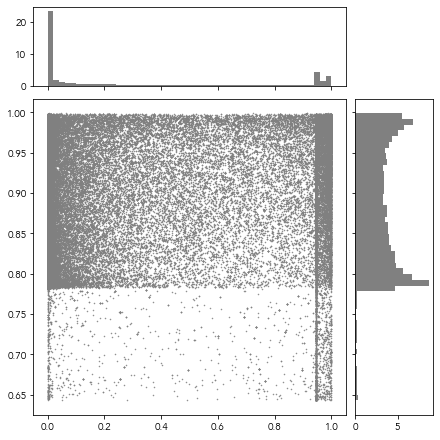

In [19]:
fig, ax_ = plt.subplot_mosaic([['a', '.'],
                               ['b', 'c']], figsize       = (6, 6),
                                            layout        = 'constrained',
                                            gridspec_kw   = dict(width_ratios  = (4, 1), 
                                                                 height_ratios = (1, 4)))

# no labels
ax_['a'].tick_params(axis = "x", labelbottom = False)
ax_['c'].tick_params(axis = "y", labelleft = False)

# the scatter plot:
ax_['b'].scatter(w_f_, w_e_, color = 'gray', s = .25)
ax_['a'].hist(w_f_, bins = 50, color = 'gray', density = True)
ax_['c'].hist(w_e_, bins = 50, color = 'gray', density = True, orientation = 'horizontal')

plt.show()

In [305]:


# plt.figure()
# plt.plot(_model['F_'].T, c = 'gray')

# plt.plot(f_ts_, label = 'actual')
# plt.plot(f_fc_ts_, label = 'day-ahead')
# plt.plot(np.mean(_model['F_'], axis = 0), label = 'mean')
# plt.plot(np.median(_model['F_'], axis = 0), label = 'median')
# plt.legend()

# plt.savefig(path_to_images + r'/sel_neighbors.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

# plt.show()

# plt.figure()
# plt.plot(_model['F_hat_'].T, c = 'gray')
# #plt.plot(np.mean(_model['F_hat_'], axis = 0))
# #plt.plot(np.median(_model['F_hat_'], axis = 0))
# plt.plot(f_ts_, label = 'actual')
# plt.plot(f_fc_ts_, label = 'day-ahead fc')
# plt.legend()

# plt.savefig(path_to_images + r'/day_ahead_forecasts.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

# plt.show()

# plt.figure()
# plt.plot(_model['E_hat_'].T, c = 'gray')
# #plt.plot(np.mean(_model['F_hat_'], axis = 0))
# #plt.plot(np.median(_model['F_hat_'], axis = 0))
# plt.plot(f_fc_ts_ - f_ts_, label = 'day-ahead fc error')
# plt.legend()

# plt.savefig(path_to_images + r'/day_ahead_errors.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

# plt.show()

In [ ]:
# def _plot_similarity_map(w_, x_tr_, x_ts_, x_, idx_0_, idx_1_, idx_2_):
    
#     z_   = (w_ - w_[idx_2_].min())/(w_[idx_2_].max() - w_[idx_2_].min())
#     idx_ = idx_2_[np.argsort(w_[idx_2_])]
#     print(z_[idx_].min(), z_[idx_].max())

#     #_cmap = plt.get_cmap('gnuplot')
#     _cmap = sns.color_palette("gnuplot", as_cmap=True)
#     _norm = plt.Normalize(0, z_[idx_].max())
    
#     fig, ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as needed

#     TX_.plot(ax        = ax, 
#              facecolor = 'lightgray', 
#              edgecolor = 'white', 
#              zorder    = 0)
    
#     ax.scatter(x_[0], x_[1], 
#                c      = 'lime', 
#                lw     = 0.5, 
#                ec     = 'k', 
#                s      = 200., 
#                zorder = 1, 
#                marker = '^', 
#                label  = 'Asset (du)') 

#     ax.plot(x_ts_[:, 0], x_ts_[:, 1], 
#             c      = 'gray', 
#             alpha  = .75,
#             ms     = 6, 
#             marker = 'o', 
#             mec    = 'w',
#             ls     = 'none', 
#             mew    = 1.,
#             zorder = 2, 
#             label  = 'Assets wo/ Scenarios') 

#     ax.plot(x_tr_[idx_1_[0], 0], x_tr_[idx_1_[0], 1], 
#             c      = _cmap(_norm(0.5)), 
#             alpha  = 0.75,
#             ms     = 6,
#             ls     = 'none',
#             marker = 'o', 
#             mec    = 'w',
#             mew    = 1.,
#             zorder = 3, 
#             label  = 'Assets w/ Similar Scenarios')

#     ax.plot(x_tr_[idx_2_[0], 0], x_tr_[idx_2_[0], 1], 
#             c      = _cmap(_norm(0.5)), 
#             alpha  = 0.75,
#             ms     = 6,
#             ls     = 'none',
#             marker = 'o', 
#             mec    = 'k',
#             mew    = 0.5,
#             zorder = 3, 
#             label  = 'Assets w/ Similar Scenarios and Close')
    
#     for i in range(idx_1_.shape[0]):
#         ax.plot(x_tr_[idx_1_[i], 0], x_tr_[idx_1_[i], 1], 
#                 c      = _cmap(_norm(z_[idx_1_[i]])), 
#                 alpha  = 0.75,
#                 ms     = 6,
#                 ls     = 'none',
#                 marker = 'o', 
#                 mec    = 'w',
#                 mew    = 1.,
#                 zorder = 3)
    
#     for i in range(idx_2_.shape[0]):
#         ax.plot(x_tr_[idx_2_[i], 0], x_tr_[idx_2_[i], 1], 
#                 c      = _cmap(_norm(z_[idx_2_[i]])), 
#                 alpha  = 0.75,
#                 ms     = 6,
#                 ls     = 'none',
#                 marker = 'o', 
#                 mec    = 'k',
#                 mew    = 0.5,
#                 zorder = 4)

#     cbar = fig.colorbar(cm.ScalarMappable(cmap = _cmap), 
#                  cax = ax.inset_axes([-97.75, 35.5, 1.75, .225], transform = ax.transData), 
#                  orientation = 'horizontal')

#     cbar.set_ticks([0, 1], labels = ['low','high'])
#     cbar.ax.tick_params(length = 0)
#     cbar.ax.set_title('Similarity', rotation = 0)
    

#     ax.legend(frameon = False, 
#               #loc     = 'upper left',
#               bbox_to_anchor = (0.375, 0.25),
#               ncol    = 1)
    
#     ax.set_axis_off()

#     plt.savefig(path_to_images + r'/similarity_map.pdf', 
#                 bbox_inches = 'tight', 
#                 dpi         = 300)
    
#     plt.show()
    

In [15]:
def _PIT_gaussian(y_true, forecast_mean, forecast_std, nbins = 100):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - mean and std: The calculated PIT
    """
            
    u_samples = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (12.5, 2.5))
    plt.hist(u_samples, bins    = nbins, 
                        density = True, 
                        alpha   = 0.7, 
                        color   = 'blue', 
                        label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()
    
def _PIT(z_, nbins = 100, file_name = 'unnamed.png'):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - z_: CDF evaluations
    - nbins: number of bins in the histogram
    """
                
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (5, 2.5))
    plt.hist(z_, bins    = nbins, 
                 density = True, 
                 alpha   = 0.7, 
                 color   = 'blue', 
                 label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    plt.ylim(0., 2,)
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()
    

    plt.savefig(path_to_images + r'/{}'.format(file_name), 
                bbox_inches = 'tight', 
                dpi         = 300)
    
    
def _KS(z_, nbins = 100):
    """
    Calculate the Kolmogorov–Smirnov (KS) statistic for a normal dist.
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - sup_ks: Kolmogorov–Smirnov statistic
    - avg_ks: Kolmogorov–Smirnov statistic but calculating RMSE instead of sup

    """
    
    #u_samples_  = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    hist_, bin_ = np.histogram(z_, nbins, density=True)
    bins_       = (bin_[:-1] + bin_[1:])/2.
    #r_ = np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))
    
    plt.figure()
    plt.plot(np.cumsum(hist_))
    plt.plot(np.cumsum(np.ones(bins_.shape)))
    plt.show()

    #avg_ks = np.sqrt(np.mean((np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape)))**2))/hist_.shape[0]
    sup_ks = np.max(np.absolute(np.cumsum(hist_) - np.cumsum(np.ones(bins_.shape))))

    return sup_ks 

In [28]:
t           = 144
forget_rate = 2
n_kNNs      = 500
i = 48
z_1_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        f_fc_ts_ = F_fc_ts_[d, t:, a]
        f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        #for i in range(48):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_1_.append(_eCDF(f_ts_[i]))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


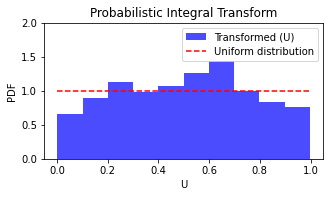

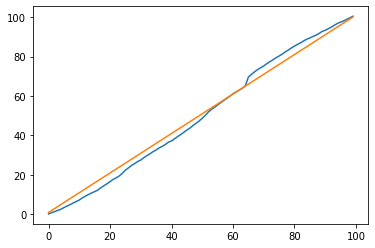

4.70764399316343

In [29]:
_PIT(np.stack(z_1_), nbins = 10, file_name = '{}_{}_{}-PIT-48.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_1_), nbins = 100)

In [30]:
t           = 144
forget_rate = 2
n_kNNs      = 500
i = 24

z_2_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
#         f_fc_ts_ = F_fc_ts_[d, t:, a]
#         f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)

        #for i in range(48):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 0.) | (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_2_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


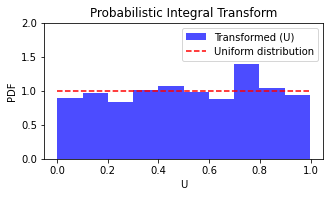

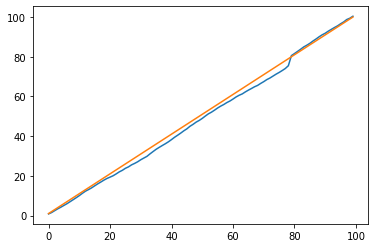

3.959867361862436

In [31]:
_PIT(np.stack(z_2_), nbins = 10, file_name = '{}_{}_{}-PIT-24.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_2_), nbins = 100)

In [32]:
t           = 144
forget_rate = 2
n_kNNs      = 500
i = 12
z_3_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        #for i in range(48):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_3_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


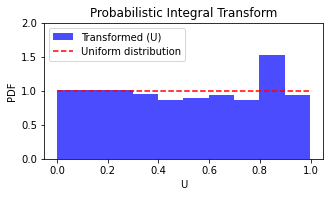

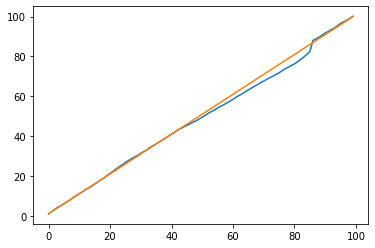

4.725702333503818

In [33]:
_PIT(np.stack(z_3_), nbins = 10, file_name = '{}_{}_{}-PIT-12.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_3_), nbins = 100)

In [34]:
t           = 144
forget_rate = 2
n_kNNs      = 500

i = 60
z_4_ = []

for a in range(20):
    print(a)
    for d in range(365):

        F_tr_, F_ts_, F_hat_tr_, F_hat_ts_, f_tr_, f_ts_ = _get_test_sample(F_ac_tr_, F_ac_ts_, F_fc_ts_p_, p_, a, d, t)
        
        # f_fc_ts_ = F_fc_ts_[d, t:, a]
        # f_fc_tr_ = F_fc_ts_[d, :t, a]
        
        _model = _fit(F_tr_, F_ts_,
                      forget_rate = forget_rate,
                      n_kNNs      = n_kNNs)

        _model = _predict(_model, F_hat_ts_, f_tr_)


        #for i in range(36):
        _eCDF = ECDF(_model['F_'][:, i])
        if (_eCDF(f_ts_[i]) == 1.):
            continue
        else:
            #z_.append(_eCDF(f_fc_ts_[i] - f_ts_[i]))
            z_4_.append(_eCDF(f_ts_[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


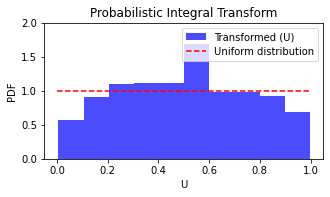

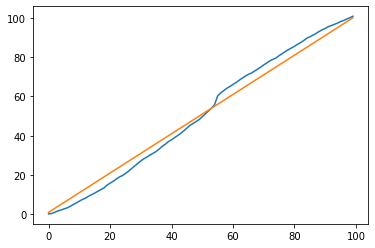

5.577859645969987

In [35]:
_PIT(np.stack(z_4_), nbins = 10, file_name = '{}_{}_{}-PIT-60.png'.format(t, forget_rate, n_kNNs))
_KS(np.stack(z_4_), nbins = 100)

In [ ]:

# # Forecast dynamic update based on distance
# def _ffc_predict(_model, f_, fc_):
    
#     F_ = _model['F_tr_']
    
#     # Smoothing observed mean and actuals
#     if (_model['smoothing'] == 1) | (_model['smoothing'] == 3): 
#         F_, f_ = _smoothing(F_, f_, _model['lambda'])

#     # phi: importance weights based on time distance
#     phi_ = _exponential_decay_minus(f_.shape[0], _model['forget_rate'])
    
#     # plt.figure(figsize = (10, 2))
#     # plt.title('Forget Rate')
#     # plt.plot(phi_)
#     # plt.ylim(-0.1,1.1)
#     # plt.show()

#     # d: euclidian distance between samples weighted by importance weights (phi)
#     d_ = _dist(F_, f_, phi_/phi_.sum())
#     # w: normalized wieghts distance across observations based on RBF kernel distance
#     w_ = _kernel(d_, _model['length_scale'])
        
#     _model['weights'] = w_/w_.sum()
    
#     # Multivariate normal assumption
#     _model = _predictive_multivariate_normal_dist(_model, fc_)

#     return _model

# Multivariate normal forecast assumption
# def _predictive_multivariate_normal_dist(_model, fc_):

#     F_ = _model['F_ts_']
#     w_ = _model['weights']  
    
#     # Mean function
#     f_hat_ = F_.T @ w_ 

#     # Regulate mean function
#     f_hat_ = _gen_constraint(f_hat_, _model['f_min'], _model['f_max'])
    
#     # Smoothing prediction: unobserved mean and actuals
#     if (_model['smoothing'] == 2) | (_model['smoothing'] == 3): 
#         F_, f_hat_ = _smoothing(F_, f_hat_, _model['lambda'])
        
#     # Fuse day-ahead forecast with real-time forecast
#     mu_hat_ = _update_forecast(F_, f_hat_, fc_, _model['trust_rate'])

#     # Covariance function
#     F_hat_ = np.repeat(mu_hat_[:, np.newaxis], F_.shape[0], axis = 1).T
#     S_hat_ = (F_ - F_hat_).T @ np.diag(w_) @ (F_ - F_hat_)
    
#     # plt.figure(figsize = (10, 2))
#     # plt.plot(f_hat_, label = 'real-time (fc)')
#     # plt.plot(fc_, label = 'day-ahead (fc)')
#     # plt.plot(mu_hat_, label = 'update (fc)')
#     # plt.ylim(-0.1,)
#     # plt.legend()
#     # plt.show()

#     # Define probability dist
#     _N = multivariate_normal(mu_hat_, S_hat_, allow_singular = True)
    
#     _model['normal'] = {}
#     _model['normal']['mean']         = mu_hat_
#     _model['normal']['covariance']   = S_hat_
#     _model['normal']['distribution'] = _N
    
#     return _model.copy()